# Analyse BlueSeis BSPF Event Analysis - Backazimuth

With pressure sensor parascientific and new sensor 

In [62]:
import os 
import obspy as obs
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from andbro__store_as_pickle import __store_as_pickle
from andbro__savefig import __savefig

## Configurations

In [58]:
workdir = "/home/andbro/Documents/ROMY/BSPF"

In [115]:
config = {}

## blueSeis sensor
config['seed_blueseis'] = "PY.BSPF..HJ*"

## Trillium 240 next to BlueSeis on Pier
config['seed_seismometer'] = "II.PFO.10.BH*" 
# config['seed_seismometer'] = "PY.BSPF..HH*" 

## BSPF coordinates
config['BSPF_lon'] = -116.455439
config['BSPF_lat'] = 33.610643


## Borrego Springs, Ca M3.2 -> good
# config['tbeg'] = obs.UTCDateTime("2023-01-09 19:42:56")-3
# config['tend'] = config['tbeg']+35
# config['fmin'], config['fmax'] = 0.1, 15.0
# config['magnitude'] = 3.2
# config['title'] = f"Borrego Springs, Ca | {config['tbeg'].date} {str(config['tbeg'].time)[:5]} UTC | M{config['magnitude']}"

## Gulf of California M6.3 -> alright
# config['tbeg'] = obs.UTCDateTime("2022-11-22 16:32")+30
# config['tend'] = config['tbeg']+1000
# config['fmin'], config['fmax'] = 0.01, 1.0
# config['magnitude'] = 6.3
# config['title'] = f"Gulf of California | {config['tbeg'].date} {str(config['tbeg'].time)[:5]} UTC | M{config['magnitude']}"

## Borrego Springs, California M4.2 -> good
config['tbeg'] = obs.UTCDateTime("2022-12-31 12:12:25")-5
config['tend'] = config['tbeg']+80
config['fmin'], config['fmax'] = 0.01, 10.0
config['magnitude'] = 4.2
config['title'] = f"Borrego Springs, Ca | {config['tbeg'].date} {str(config['tbeg'].time)[:5]} UTC | M{config['magnitude']}"

## store config
__store_as_pickle(config, f"./configs/{str(config['tbeg'].date).replace('-','')}_M{config['magnitude']}.pkl")

## Load Data

In [100]:
def __request_data(seed, tbeg, tend):

    from obspy.clients.fdsn import Client

    client = Client("IRIS")

    net, sta, loc, cha = seed.split(".")

    try:
        inventory = client.get_stations(network=net, 
                                         station=sta,
                                         starttime=tbeg,
                                         endtime=tend,
                                         level="response",
                                         )
    except:
        print("Failed to load inventory!")
        inventory = None
        
    try:
        waveform = client.get_waveforms(network=net,
                                       station=sta,
                                       location=loc,
                                       channel=cha, 
                                       starttime=tbeg-60,
                                       endtime=tend+60,
                                       )

    except:
        print("Failed to load waveforms!")
        waveform = None
    
    return waveform, inventory

In [101]:
py_bspf0, py_bspf_inv = __request_data(config['seed_blueseis'], config['tbeg'], config['tend'])

In [102]:
ii_pfo0, ii_pfo_inv = __request_data(config['seed_seismometer'], config['tbeg'], config['tend'])

## PreProcessing

In [103]:
def __process_acc_data(config, st, inv):
    
    ii_pfo_acc = st.copy()

    pre_filt = [0.005, 0.01, 19, 20]

    ## cut properly
    ii_pfo_acc.trim(config['tbeg'], config['tend'])

    ## demean
    ii_pfo_acc.detrend("demean")

    ## remove response
    ii_pfo_acc.remove_response(inventory=inv, 
                           pre_filt=pre_filt, 
                           output="ACC",
#                            water_level=60, 
                           plot=False)

    ## taper 
    ii_pfo_acc.taper(0.1)

    ## bandpass
    ii_pfo_acc.filter("bandpass", freqmin=config['fmin'], freqmax=config['fmax'], corners=8, zerophase=True)

    ## remove mean
    ii_pfo_acc.detrend("demean")
    
    ## adjust channel names
    for tr in ii_pfo_acc:
        if tr.stats.channel[-1] == "1":
            tr.stats.channel = str(tr.stats.channel).replace("1","N")
        if tr.stats.channel[-1] == "2":
            tr.stats.channel = str(tr.stats.channel).replace("2","E")

    ## show stream
    print(ii_pfo_acc)
            
    ii_pfo_acc.plot(equal_scale=False);
    
    return ii_pfo_acc

3 Trace(s) in Stream:
II.PFO.10.BHN | 2022-12-31T12:12:19.994538Z - 2022-12-31T12:13:39.994538Z | 40.0 Hz, 3201 samples
II.PFO.10.BHE | 2022-12-31T12:12:19.994538Z - 2022-12-31T12:13:39.994538Z | 40.0 Hz, 3201 samples
II.PFO.10.BHZ | 2022-12-31T12:12:19.994538Z - 2022-12-31T12:13:39.994538Z | 40.0 Hz, 3201 samples


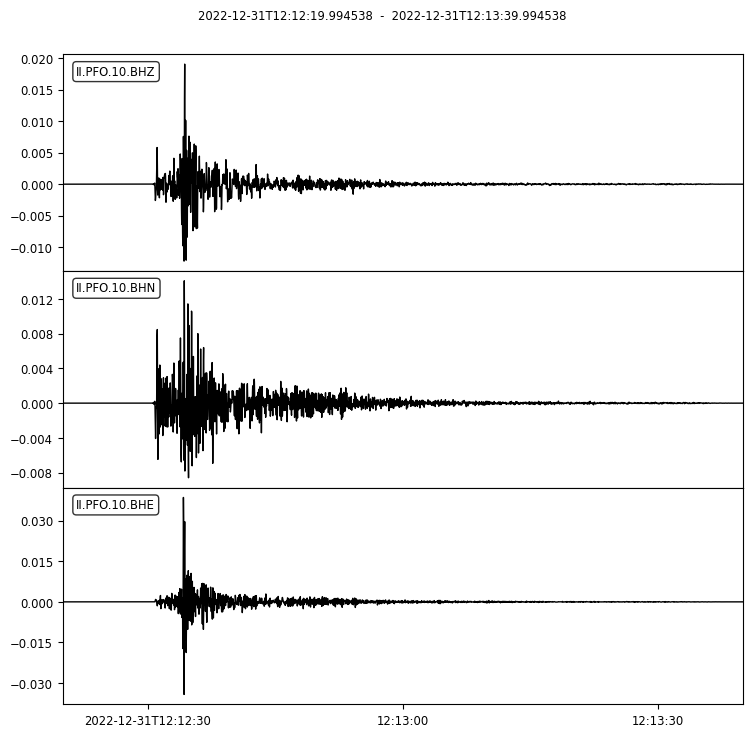

In [104]:
ii_pfo_acc = __process_acc_data(config, ii_pfo0, ii_pfo_inv)

In [105]:
def __process_rot_data(config, st, inv):
    
    py_bspf = st.copy()

    ## merge traces that might be split due to data gaps or overlaps
    py_bspf.merge(fill_value="interpolate")

    ## cut to event
    py_bspf.trim(config['tbeg'], config['tend'])

    ## renove sensitivity
    py_bspf.remove_sensitivity(inv)

    ## remove mean
    py_bspf.detrend("demean")

    ## apply taper
    py_bspf.taper(0.1)

    ## bandpass filter
    py_bspf.filter("bandpass", freqmin=config['fmin'], freqmax=config['fmax'], corners=8, zerophase=True)

    ## remove mean
    py_bspf.detrend("demean")    
    
    ## resample to 40 Hz as acc data
    py_bspf.resample(40)
    
    ## adjust channel names
    for tr in py_bspf:
        if tr.stats.channel[-1] == "1":
            tr.stats.channel = str(tr.stats.channel).replace("1","E")
        if tr.stats.channel[-1] == "2":
            tr.stats.channel = str(tr.stats.channel).replace("2","N")        
        if tr.stats.channel[-1] == "3":
            tr.stats.channel = str(tr.stats.channel).replace("3","Z")

    ## show all traces in data stream
    print(py_bspf)

    py_bspf.plot(equal_scale=False);

    return py_bspf

3 Trace(s) in Stream:
PY.BSPF..HJE | 2022-12-31T12:12:19.998700Z - 2022-12-31T12:13:39.973700Z | 40.0 Hz, 3200 samples
PY.BSPF..HJN | 2022-12-31T12:12:19.998700Z - 2022-12-31T12:13:39.973700Z | 40.0 Hz, 3200 samples
PY.BSPF..HJZ | 2022-12-31T12:12:19.998800Z - 2022-12-31T12:13:39.973800Z | 40.0 Hz, 3200 samples


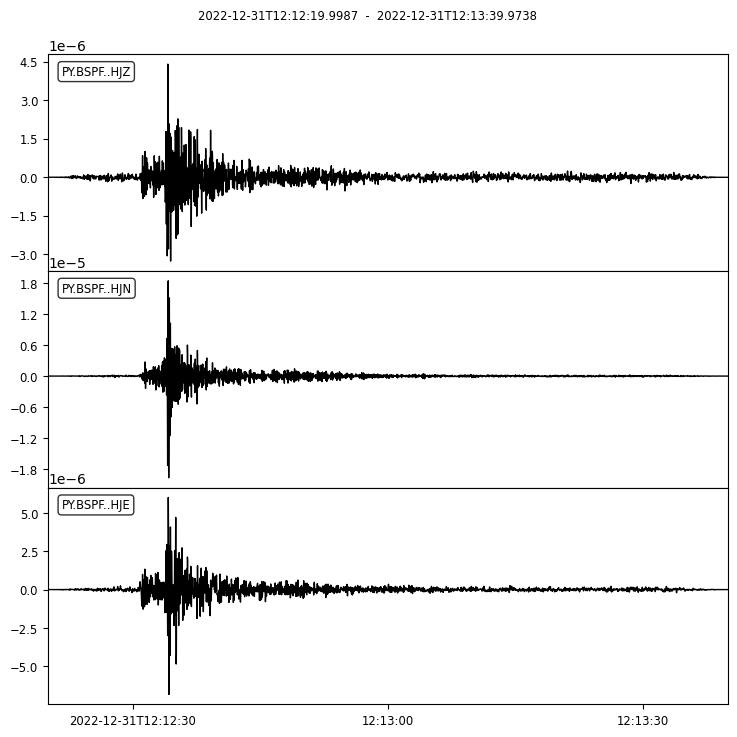

In [106]:
py_bspf = __process_rot_data(config, py_bspf0, py_bspf_inv)

## Computations

In [116]:
from obspy import read, read_events, UTCDateTime
from obspy.clients.fdsn import Client
from obspy.geodetics.base import gps2dist_azimuth
import numpy as np

ACC = ii_pfo_acc.trim(config['tbeg']+1, config['tend']-1)
ROT = py_bspf.select(component="Z").trim(config['tbeg']+1, config['tend']-1)

In [117]:
def __get_directions(config):
    
    from obspy.clients.fdsn import Client
    from obspy.geodetics.base import gps2dist_azimuth
    
    ## get event information from catalog
    cat = Client("IRIS").get_events(starttime=config['tbeg']-10, 
                                    endtime=config['tend']+10, 
                                    minmagnitude=config['magnitude']-0.1
                                   )
    
    ## allocate first event
    config['event'] = cat[0]
    
    print(cat, "|", config['event'].event_descriptions[0]['type'], ': ', config['event'].event_descriptions[0]['text'], "\n")

    # event location from event info
    source_latitude = config['event'].origins[0].latitude
    source_longitude = config['event'].origins[0].longitude

    # theoretical backazimuth and distance
    config['baz'] = gps2dist_azimuth(source_latitude, source_longitude, 
                                     config['BSPF_lat'], config['BSPF_lon'],
                                     )

    print('Epicentral distance [m]:       ',np.round(config['baz'][0],1))
    print('Theoretical azimuth [deg]:     ', np.round(config['baz'][1],1))
    print('Theoretical backazimuth [deg]: ', np.round(config['baz'][2],1))

In [118]:
__get_directions(config)

1 Event(s) in Catalog:
2022-12-31T12:12:26.650000Z | +33.398, -116.393 | 4.3 ML | Flinn-Engdahl region :  SOUTHERN CALIFORNIA 

Epicentral distance [m]:        24334.6
Theoretical azimuth [deg]:      346.3
Theoretical backazimuth [deg]:  166.3


In [119]:
def __compute_backazimuth_collection(config, ROT, ACC):

    from obspy.signal.cross_correlation import xcorr
    from obspy.signal.rotate import rotate_ne_rt
    from numpy import array, meshgrid
    
    
    ## sampling rate of rotations    
    sampling_rate = int(ROT.select(channel="*Z")[0].stats.sampling_rate)
    
    ## window length for correlation (in seconds)
#     sec = 1
    sec = config['window_length']

    ## overlap (in percent)
#     overlap = 25
    overlap = config['window_overlap']
    
    ## step length for backazimuth sampling
    step = 10
    
    ## number of windows
    num_windows = len(ROT.select(channel="*Z")[0]) // (int(sampling_rate * sec))
    
    # estimate the Backazimuth for each time window
    backas = np.linspace(0, 360 - step, int(360 / step))
    corrbaz = []
    ind=None

    for i_deg in range(0, len(backas)):
        for i_win in range(0, num_windows):
            
            ## infer indices
            idx1, idx2 = int(sampling_rate * sec * i_win), int(sampling_rate * sec * (i_win + 1))
            
            ## add overlap
            if i_win > 0 and i_win < num_windows:
                idx1 = int(idx1 - overlap/100 * sec * sampling_rate)
                idx2 = int(idx2 + overlap/100 * sec * sampling_rate)
                    
            
            ## rotate NE to RT
            R, T = rotate_ne_rt(ACC.select(component='N')[0].data, 
                                ACC.select(component='E')[0].data,
                                backas[i_deg]
                               )

            ## compute correlation for backazimuth
            corrbazz = xcorr(ROT.select(channel="*Z")[0][idx1:idx2], 
                             T[idx1:idx2], 0,
                            )

            corrbaz.append(corrbazz[1])

    corrbaz = array(corrbaz)
    corrbaz = corrbaz.reshape(len(backas), num_windows)

    ## extract maxima
    maxcorr = array([backas[corrbaz[:, l1].argmax()] for l1 in range(0, num_windows)])

    ## create mesh grid
    mesh = meshgrid(np.arange(sec/2, sec * num_windows, sec), backas)
   
    return mesh, corrbaz, maxcorr 

In [164]:
config['window_length'] = 1  ## in seconds
config['window_overlap'] = 50 ## in percent

mesh, corrbaz, maxcorr = __compute_backazimuth_collection(config, ROT, ACC)

/home/andbro/anaconda3/envs/obs/lib/python3.7/site-packages/obspy/signal/cross_correlation.py:390: ObsPyDeprecationWarning: Call to deprecated function xcorr(). Please use the correlate and xcorr_max functions.
  warnings.warn(msg, ObsPyDeprecationWarning)


In [165]:
def __get_arrivals(config):

    from obspy.taup import TauPyModel

    TauPy_model = TauPyModel('ak135')

    times = {}
    
    arrivals_p = TauPy_model.get_travel_times(
                                                distance_in_degree=0.001 * config['baz'][0] / 111.11,
                                                source_depth_in_km=config['event'].origins[0].depth*0.001,
                                                phase_list=["P","p","Pdiff","PP","PKiKP","PKIKP","Pn","Pg"]
                                              )

    arrivals_s = TauPy_model.get_travel_times(
                                                distance_in_degree=0.001 * config['baz'][0] / 111.11,
                                                source_depth_in_km=config['event'].origins[0].depth*0.001,
                                                phase_list=["S","s","Sdiff","SS","SKiKS","SKIKS","Sn","Sg"]
                                              )

    times['times_p'] = [i.time for i in arrivals_p]
    times['times_s'] = [j.time for j in arrivals_s]
    
    # first arrivals
    times['min_p'] = min(times['times_p'])
    times['min_s'] = min(times['times_s'])
    
    return times

In [166]:
times = __get_arrivals(config)

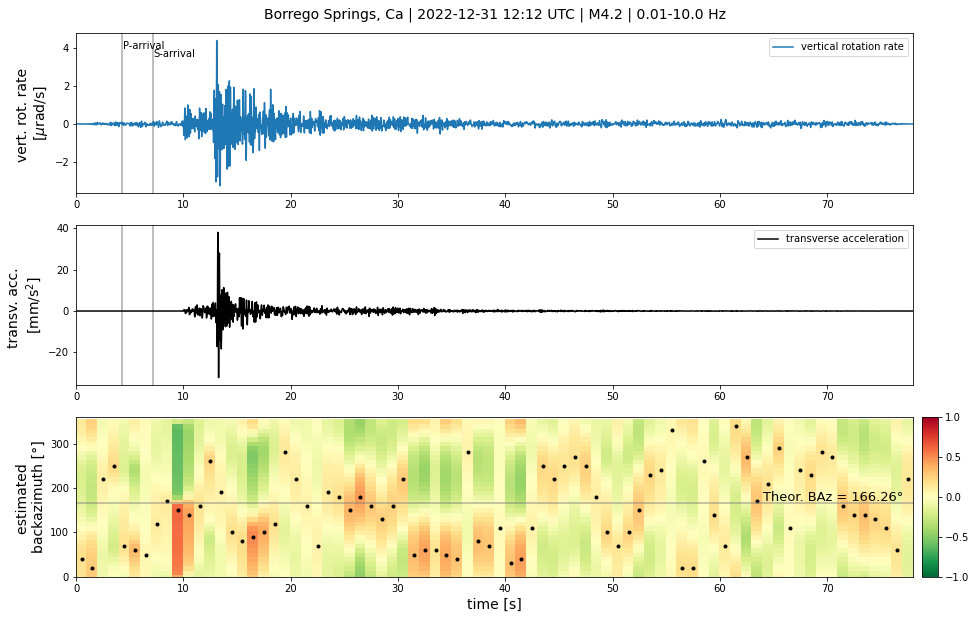

In [167]:
def __makeplot():

    import matplotlib as mpl
    
    from obspy.signal.rotate import rotate_ne_rt

    ## get rotated acceleration
    R, T = rotate_ne_rt(ACC.select(component='N')[0].data, 
                        ACC.select(component='E')[0].data,
                        config['baz'][2]
                       )
    
    fig, ax = plt.subplots(3, 1, figsize=(15, 10))

    font = 14
    
    acc_scaling, acc_unit = 1e3, "mm/s$^2$"
    rot_scaling, rot_unit = 1e6, "$\mu$rad/s"
    
    ## create time axis
    time = np.linspace(0, len(ACC[0].data)/ACC[0].stats.sampling_rate, len(ACC[0].data))
    
    ## plot vertical rotation rate
    ax[0].plot(time, ROT.select(channel="*Z")[0].data*rot_scaling, label='vertical rotation rate')
    
    ax[0].set_xlim(time[0], time[-1])
    ax[0].set_ylabel(f'vert. rot. rate \n[{rot_unit}]', fontsize=font)
    ax[0].legend()

    # add P- and S-wave arrivals
    ROT_max = max(ROT.select(channel="*Z")[0].data*rot_scaling)

    ax[0].axvline(times['min_p'], color='darkgrey', zorder=0);
    ax[0].annotate('P-arrival', xy=(times['min_p']+.1, ROT_max-0.1*ROT_max), xycoords='data');
    
    ax[0].axvline(times['min_s'], color='darkgrey', zorder=0);
    ax[0].annotate('S-arrival', xy=(times['min_s']+.1, ROT_max-0.2*ROT_max), xycoords='data');
    
    ## plot transverse acceleration
    ax[1].plot(time, T*acc_scaling, 'k',label='transverse acceleration')
    ax[1].set_xlim(time[0], time[-1])
    ax[1].set_ylabel(f'transv. acc. \n[{acc_unit}]', fontsize=font)
    ax[1].ticklabel_format(axis='y', style='sci', scilimits=(-2,2))
    ax[1].legend()
    ax[1].axvline(times['min_p'], color='darkgrey', zorder=0);
    ax[1].axvline(times['min_s'], color='darkgrey', zorder=0);

    ## backazimuth estimation plot
    im = ax[2].pcolormesh(mesh[0], mesh[1], corrbaz, cmap=plt.cm.RdYlGn_r, vmin=-1, vmax=1, shading="auto")
    ax[2].set_xlim(time[0], time[-1])
    ax[2].set_ylim(0, 360)
    ax[2].set_ylabel(u'estimated \nbackazimuth [°]', fontsize=font)
    ax[2].set_xlabel('time [s]', fontsize=font)
    
    ## plot maximal correclation values
    ax[2].plot(np.arange(config['window_length']/2., config['window_length'] * len(maxcorr), config['window_length']), maxcorr, '.k')

    ## plot theoretical Backazimuth for comparison
    xx = np.arange(0, config['window_length'] * len(maxcorr) + 1, config['window_length'])
    tba = np.ones(len(xx)) * config['baz'][2]
    
    ax[2].plot(xx, tba, c='.5', lw=1.5, alpha=0.6)
    ax[2].text(time[int(0.82*len(time))], 
               config['baz'][2]+5, 
               u'Theor. BAz = '+str(round(config['baz'][2],2))+'°', 
               color='k',
               fontsize=font-1,
              )

    ax[0].set_title(config['title'] + f" | {config['fmin']}-{config['fmax']} Hz", pad=15, fontsize=font)
    
    # add colorbar
#     norm = mpl.colors.Normalize(vmin=-1, vmax=1)
#     cb1 = mpl.colorbar.ColorbarBase(fig, cmap=plt.cm.RdYlGn_r, norm=norm, orientation='vertical')
    cax = ax[2].inset_axes([1.01, 0., 0.02, 1])
    cb1 = plt.colorbar(im, ax=ax[2], cax=cax)
    
    plt.show();
    return fig

__makeplot();